![cabinetry logo](_static/cabinetry_logo_small.png)

To run this notebook outside of the provided Binder environment, you need `cabinetry`. You can install it with `pip` by uncommenting the cell below. The `[contrib]` setup extra installs libraries that are not needed for the core `cabinetry` logic, but for `ROOT` file handling and plotting. We will also install the `tensorflow` backend for `pyhf` here for a demonstration below, as well as `hist` (again, not needed if running via Binder).

In [1]:
#! pip install cabinetry[contrib]
#! pip install pyhf[tensorflow,contrib]
#! pip install hist[plot]

<br>

`cabinetry` outputs text with the Python `logging` module. We use a helper function to set some sensible defaults, but you are welcome to customize this to your own needs.

In [2]:
import cabinetry
cabinetry.set_logging()

<br>
We will also set up additional imports that are used later on in this notebook.

In [3]:
import copy
import json
import pathlib

import boost_histogram as bh
import hist
import numpy as np
import pyhf
from pyhf.contrib.utils import download

<br>

We will have a look at three different ways of using `cabinetry` in this notebook:
- creating a statistical model,
- performing statistical inference with our model,
- exploring the statistical model of an ATLAS analysis.

There is also bonus material at the end for you to look through.

<br>

# Creating a statistical model
Statistical models are constructed following instructions in a configuration. You can specify your model in a configuration in `YAML` or `JSON` format, or alternatively as a Python dictionary. Here we will go the dictionary route. Have a look at the `config_example.yml` file for a `YAML` example.

<br>

### Defining the model

There are a few things we need. First up, some general settings:

In [4]:
config = {
   "General":{
      "Measurement": "minimal_example",
      "POI": "Signal_norm",              # parameter of interest, which we want to measure 
      "InputPath": "input/{SamplePath}", # where to find input data
      "HistogramFolder": "histograms/"

   }
}

Note the `input/{SamplePaths}` structure, which we will get back to shortly.

Now it is time to think more about physics, let's define a phase space region that contains data we want to fit to.

In [5]:
config.update({
   "Regions":[
      {
         "Name": "Signal_region",
         "Filter": "lep_charge > 0",           # event selection 
         "Variable": "jet_pt",                 # which variable we bin histograms in
         "Binning": [200, 300, 400, 500, 600]
      }
   ]
})

`"Regions"` is a list, because we can use events from more than one phase space region.

We also need to specify where our observed data is stored. Considerations about physics become important now: which types of processes do we expect to show up in this phase space region? We list them below, those samples are typically simulated with Monte Carlo methods.

In [6]:
config.update({
   "Samples":[
      {
         "Name": "Data",
         "Tree": "pseudodata",
         "SamplePath": "data.root",
         "Data": True                       # observed data is handled differently, need to distinguish
      },
      {
         "Name": "Signal",
         "Tree": "signal",
         "SamplePath": "prediction.root",
         "Weight": "weight"                 # weights: Monte Carlo integration, simulation correction etc.
      },
      {
         "Name": "Background",
         "Tree": "background",
         "SamplePath": "prediction.root",
         "Weight": "weight"
      }
   ]
})

`"Samples"` is again a list, allowing us to include arbitrarly many different types of processes we may need to consider. The `"SamplePath"` option replaces the placeholder in `input/{SamplePath}`, and specifies where each sample can be found (see the [documentation](https://cabinetry.readthedocs.io/en/latest/core.html#input-file-path-specification-for-ntuples)).

We are almost done defining our statistical model. What about systematic uncertainties? For now, we won't define any.

In [7]:
config.update({"Systematics": []})

<br>

There is one more thing we need though: we said our POI (parameter of interest) was `"Signal_norm"`. That is a normalization factor, describing the normalization of somthing. We still need to define what it does!

In [8]:
config.update({
   "NormFactors":[
      {
         "Name": "Signal_norm",
         "Samples": "Signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [-5, 10]
      }
   ]
})

<br>

It is a good idea to validate that our configuration satisfies the `cabinetry` configuration schema.

In [9]:
cabinetry.configuration.validate(config)

True

<br>

That looks good, but is not sufficient to be sure that everything is fine (some things will only show up at runtime). If we use some settings `cabinetry` does not know, or forget some it expects, we would see an error. We can also get some summary information about the configuration we defined.

In [10]:
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   0 Systematic(s)


<br>

### Creating histograms

We now need to create the required histograms for our statistical model. `cabinetry` implements the logic to figure out which histograms are needed, to create all instructions, and to send those off for execution. You can view our `config` as a generic specification and `cabinetry` as the reference implementation handling it, but you could just as well use your own code to interact with the specification. 

In [11]:
cabinetry.templates.build(config, method="uproot")

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background.npz


`cabinetry` used `uproot` and `boost-histogram` to create three histograms for us: the distribution of our three samples in the one phase space region we defined. We also see a warning: there are no expected signal events in the first bin of the histogram.

The histograms are saved to the folder specified under HistogramFolder in the General settings in the configuration file. In this case, this folder is histograms/:

In [12]:
!ls histograms

Signal_region_Background.npz Signal_region_Signal.npz
Signal_region_Data.npz


A post-processing step can be run to apply optional operations like histogram smoothing. See the bonus material.

In [13]:
cabinetry.templates.postprocess(config)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal_modified.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_modified.npz


You can also provide existing histograms you built yourself for `cabinetry` to use, see the [cabinetry-tutorials](https://github.com/cabinetry/cabinetry-tutorials) repository for an example.

<br>
Let's visualize the histograms we have produced.

INFO - cabinetry.visualize - visualizing histogram
INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_prefit.pdf


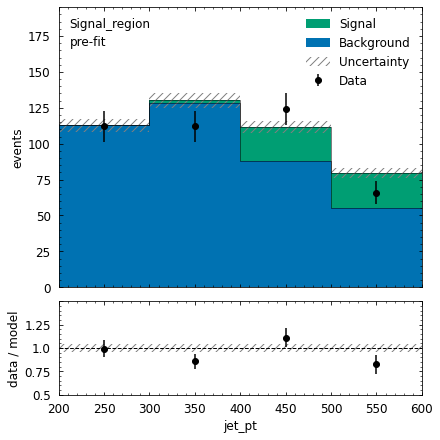

In [14]:
_ = cabinetry.visualize.data_mc_from_histograms(config)

We see our expected distributions of signal and background, as well as our observed (pseudo-) data.

<br>

### A more complex model: adding systematic uncertainties

Let's make our model a bit more realistic and add a few systematic uncertainties:
- a 5% luminosity uncertainty,
- a `Modeling` uncertainty derived from comparing our nominal background prediction to that of a different simulator,
- a `WeightBasedModeling` modeling uncertainty derived from varying the weights we apply to background events.

In [15]:
config.update({
   "Systematics":[
      {
         "Name": "Luminosity",
         "Up": {"Normalization": 0.05},
         "Down": {"Normalization": -0.05},
         "Type": "Normalization"
      },
      {
         "Name":"Modeling",
         "Up": {"Tree": "background_varied"},
         "Down": {"Symmetrize": True},
         "Samples": "Background",
         "Type": "NormPlusShape"
      },
      {
         "Name": "WeightBasedModeling",
         "Up": {"Weight": "weight_up"},
         "Down": {"Weight": "0.7*weight"},
         "Samples": "Background",
         "Type": "NormPlusShape"
      }
   ],
})

<br>
These new systematic uncertainties require new histograms, so let's build those.

In [16]:
cabinetry.templates.build(config, method="uproot")
cabinetry.templates.postprocess(config)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_WeightBasedModeling_Up.n

<br>
We can visualize the template histograms corresponding to systematic variations of our model.

INFO - cabinetry.visualize - visualizing systematic templates
INFO - cabinetry.visualize.utils - saving figure as figures/templates/Signal_region_Background_Modeling.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/templates/Signal_region_Background_WeightBasedModeling.pdf


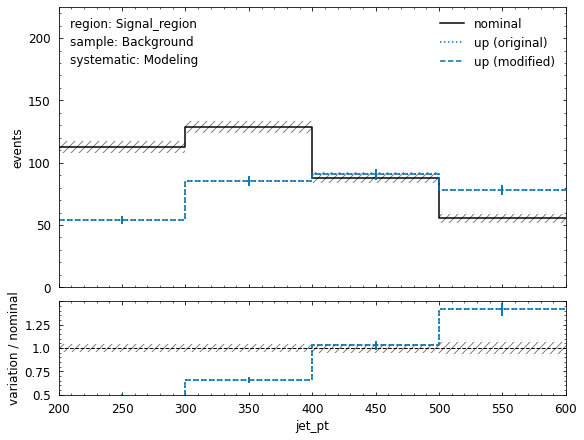

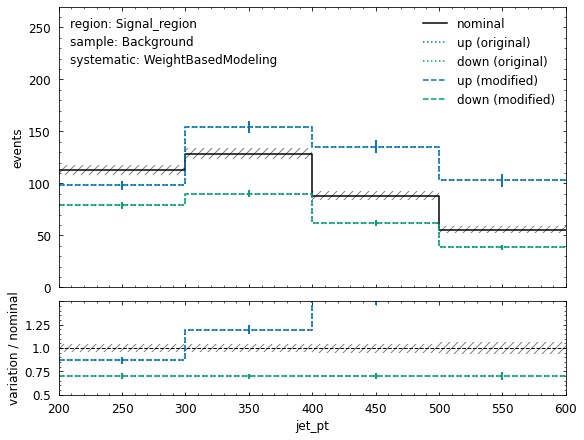

In [17]:
_ = cabinetry.visualize.templates(config)

The top figure is our `Modeling` uncertainty, where we compare our nominal background prediction to that of another simulator, here called the "up" variation. At the bottom are the weight-based variations: you can see the "down" variation, defined by multiplying the nominal weight by `0.7`, is a factor `0.7` smaller than nominal.

<br>

### Building a workspace

With all relevant histograms available, we can now construct a `pyhf` workspace. This is our serialized fit model. It contains everything needed to construct a likelihood function via `pyhf`, which is then used for inference.

In [18]:
workspace_path = "example_workspace.json"
spec = cabinetry.workspace.build(config)
cabinetry.workspace.save(spec, workspace_path)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor Signal_norm to sample Signal in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys Luminosity to sample Signal in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys Luminosity to sample Background in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys Modeling to sample Background in region Signal_region
DEBUG - cabinetry.workspace - normalization impact of systematic Modeling on sample Background in region Signal_region is 0.800
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys WeightBasedModeling to sample Background in region Signal_region
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to example_workspace.json


Saving is optional, we could directly continue with the `ws` object. `pyhf` has validated our workspace, and we are now ready for statistical inference.

<br>

### Model structure

It can be helpful to visualize the modifier structure of the statistical model we have built to catch potential issues. The `visualize.modifier_grid` function creates a figure showcasing the information about which modifiers (indicated by color) act on which region and sample when a given parameter (on the horizontal axis) is varied. To split this visualization from one table per region to one table per sample, use `split_by_sample=True`.

We need the fit model (containing the probability density function) for the visualization, which we create from the workspace specification. We directly use the `pyhf` API for this here, in the next section you will see the `cabinetry` API used for the same task.

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier Modeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier WeightBasedModeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Luminosity (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_Signal_region (4 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


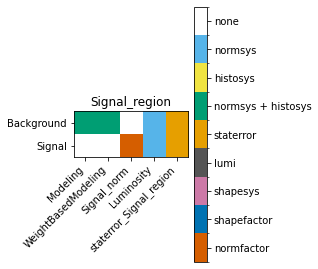

In [19]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

Our model here is not very complex, for a more complex example and the accompanying visualization see [these figures](https://github.com/scikit-hep/cabinetry/issues/332#issuecomment-1214245346).

<br>

# Performing statistical inference with our model

To perform inference, we need two things: a probability density function (pdf), or `model`, and data to fit it to. Both are derived from the workspace specification.

In [20]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier Modeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier WeightBasedModeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Luminosity (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_Signal_region (4 new nuisance parameters)


You can see our `Signal_norm` normalization showing up, in addition to parameters for the systematic uncertainties we defined.

There is also `staterror_Signal_region`: these are parameters automatically created by `cabinetry` to encode systematic uncertainty due to the finite sample size of our predicted distributions for signal and background.

`data` is a list, starting with the observed counts per bin.

In [21]:
data

[112.0, 112.0, 124.0, 66.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]

What comes after is so-called auxiliary data. Check out [this `pyhf` tutorial](https://pyhf.github.io/pyhf-tutorial/HelloWorld.html#auxiliary-data) to learn more about this important concept. You can view it as data observed in previous measurements, which inform our current model. In this case the auxiliary data is associated to the `staterror_Signal_region` parameter. 

<br>

### Maximum likelihood estimate (MLE)

Let's fit our model to data to obtain the maximum likelihood estimate (MLE).

In [22]:
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 310              │
│ EDM = 2.82e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

<br>
The fit converged, and we see the best-fit parameter results reported. The results are stored in a named tuple. This allows for easy access of the results.

In [23]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

Modeling: -0.326 +/- 0.555
WeightBasedModeling: -0.587 +/- 0.627
Signal_norm: 1.693 +/- 0.946
Luminosity: -0.090 +/- 0.991
staterror_Signal_region[0]: 1.001 +/- 0.041
staterror_Signal_region[1]: 0.989 +/- 0.038
staterror_Signal_region[2]: 1.020 +/- 0.037
staterror_Signal_region[3]: 0.983 +/- 0.043


<br>

It is helpful to visualize the fit results. Let's start with the *pull plot* showing us best-fit parameter results.

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


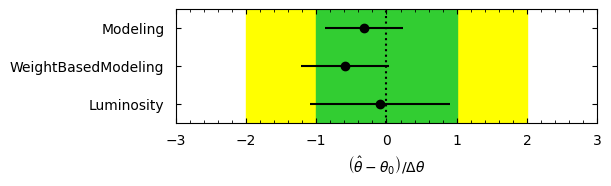

In [24]:
cabinetry.visualize.pulls(fit_results, exclude="Signal_norm")

<br>

The parameter correlation matrix has a handy `pruning_threshold` setting to filter out parameters that are not highly correlated with others.

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


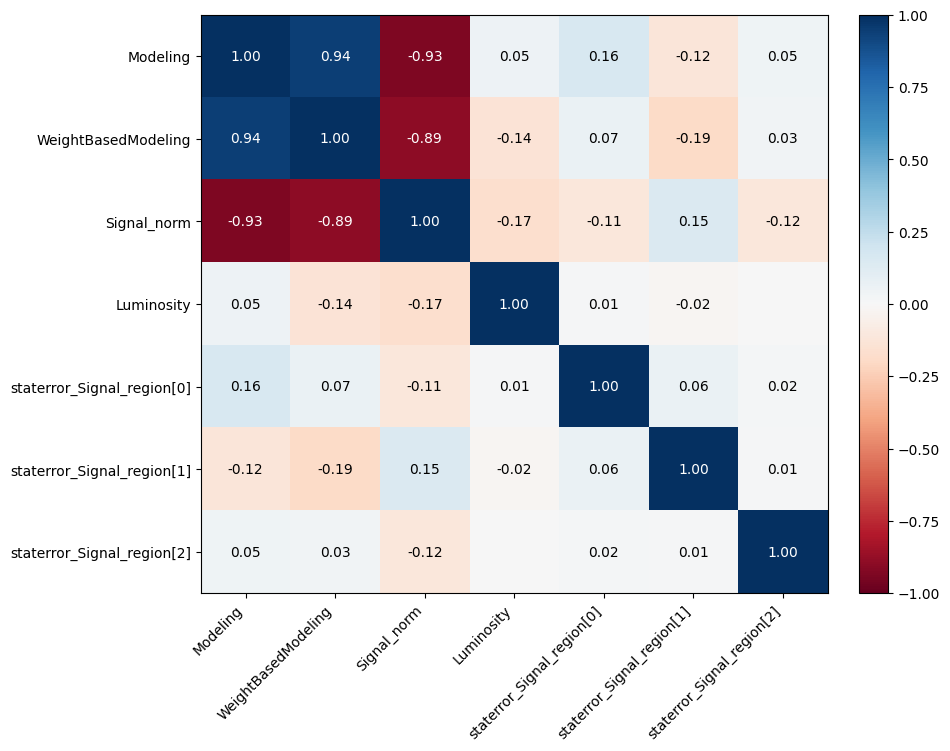

In [25]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.1)

<br>
How does the model look like after fit to data? Let's first look again at the model before the fit to data. We use information from the workspace for plotting, and from the config for cosmetics (axis label / binning). The results include the effect of systematic uncertainties.

DEBUG - cabinetry.model_utils - total stdev is [[69, 58.3, 38.2, 45.3]]
DEBUG - cabinetry.model_utils - total stdev per channel is [137]
INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_prefit.pdf


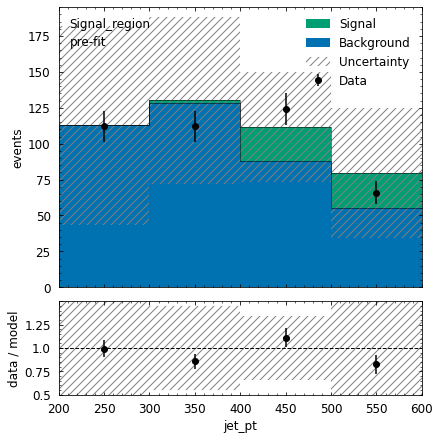

In [26]:
model_pred = cabinetry.model_utils.prediction(model)
figures = cabinetry.visualize.data_mc(model_pred, data, config=config)

It is possible to edit the figures created by `cabinetry` using the `matplotlib` API. The example below modifies an axis label to use $\LaTeX$.

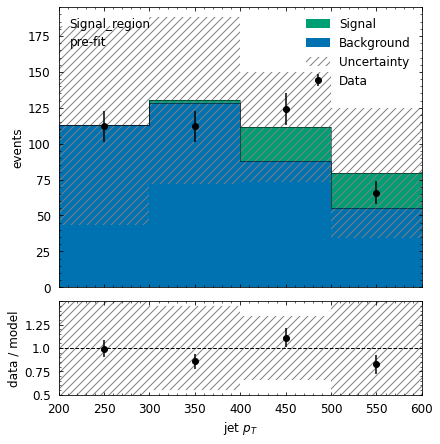

In [27]:
ratio_panel = figures[0]["figure"].get_axes()[1]
ratio_panel.set_xlabel("jet $p_T$")
figures[0]["figure"]  # show figure again

Yield tables can also be created from a model prediction, and compared to data. Optional keyword arguments control whether yields per bin are shown (`per_bin=True`, default) and whether bins summed per region are shown (`per_channel=True`, disabled by default). The yield table is also saved to disk by default, in a format customizable via the `table_format` argument.

In [28]:
_ = cabinetry.tabulate.yields(model_pred, data)

INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒════════════╤═════════════════╤════════════════╤════════════════╤═══════════════╕
│ sample     │ Signal_region   │                │                │               │
│            │ bin 1           │ bin 2          │ bin 3          │ bin 4         │
╞════════════╪═════════════════╪════════════════╪════════════════╪═══════════════╡
│ Background │ 112.74 ± 69.04  │ 128.62 ± 58.33 │ 88.11 ± 37.97  │ 55.25 ± 45.14 │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ Signal     │ 0.00 ± 0.00     │ 1.59 ± 0.10    │ 23.62 ± 1.49   │ 24.55 ± 1.62  │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ total      │ 112.74 ± 69.04  │ 130.21 ± 58.34 │ 111.72 ± 38.22 │ 79.79 ± 45.30 │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ data       │ 112.00          │ 112.00         │ 124.00         │ 66.00         │
╘════════════╧

This table was also saved to disk.

In [29]:
!cat tables/yields_per_bin_pre-fit.txt

sample      Signal_region    Signal_region    Signal_region    Signal_region
            bin 1            bin 2            bin 3            bin 4
----------  ---------------  ---------------  ---------------  ---------------
Background  112.74 ± 69.04   128.62 ± 58.33   88.11 ± 37.97    55.25 ± 45.14
Signal      0.00 ± 0.00      1.59 ± 0.10      23.62 ± 1.49     24.55 ± 1.62
total       112.74 ± 69.04   130.21 ± 58.34   111.72 ± 38.22   79.79 ± 45.30
data        112.00           112.00           124.00           66.00


<br>

We create the post-fit version of this plot by passing in `fit_results`.

DEBUG - cabinetry.model_utils - total stdev is [[11.9, 7.28, 7.47, 7.67]]
DEBUG - cabinetry.model_utils - total stdev per channel is [20.6]
INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_postfit.pdf


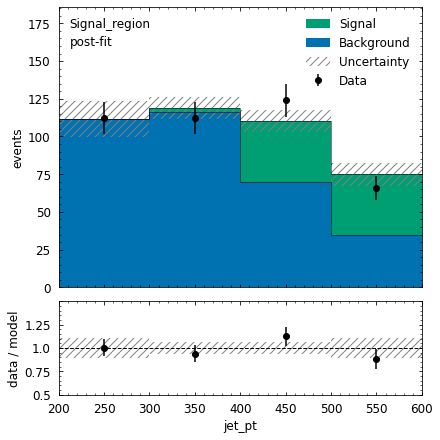

In [30]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=config)


The contribution of signal in green has increased, consistent with the normalization `Signal_norm` having been fit to a value greater than `1`.

<br>

### Expected sensitivity with the Asimov dataset

We can evaluate the expected performance of our model with the so-called Asimov dataset (see [arXiv:1007.1727](https://arxiv.org/abs/1007.1727)).

In [31]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.3                       │              Nfcn = 198              │
│ EDM = 3.05e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

By definition, none of the parameters are pulled away from their initial values in this fit.

<br>

### Beyond MLEs: discovery significance and parameter limits

Now that we ran a basic fit, let's do something slightly more involved: calculate discovery significance.

In [32]:
significance_results = cabinetry.fit.significance(model, data)

INFO - cabinetry.fit - calculating discovery significance for Signal_norm
INFO - cabinetry.fit - observed p-value: 3.584%
INFO - cabinetry.fit - observed significance: 1.801
INFO - cabinetry.fit - expected p-value: 14.775%
INFO - cabinetry.fit - expected significance: 1.046


The results are again packaged up in a named tuple. The observed significance is higher than the expected significance, consistent with fitting a `Signal_norm` value above one.

We can also calculate expected and observed 95% confidence level upper parameter limits with the [CLs method](https://doi.org/10.1088%2F0954-3899%2F28%2F10%2F313). The implementation uses Brent bracketing to find `CLs=0.05` crossings. Let's use slightly different data for this: it is simple to switch out!

INFO - cabinetry.fit - calculating 95% confidence level upper limit for Signal_norm
DEBUG - cabinetry.fit - setting lower parameter bound for POI to 0
INFO - cabinetry.fit - determining observed upper limit
DEBUG - cabinetry.fit - Signal_norm = 0.1000, observed CLs = 0.9222
DEBUG - cabinetry.fit - Signal_norm = 10.0000, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 9.4633, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 4.7816, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 2.4408, observed CLs = 0.0181
DEBUG - cabinetry.fit - Signal_norm = 1.2704, observed CLs = 0.2544
DEBUG - cabinetry.fit - Signal_norm = 2.2830, observed CLs = 0.0288
DEBUG - cabinetry.fit - Signal_norm = 1.9986, observed CLs = 0.0606
DEBUG - cabinetry.fit - Signal_norm = 2.0935, observed CLs = 0.0479
DEBUG - cabinetry.fit - Signal_norm = 2.0777, observed CLs = 0.0498
DEBUG - cabinetry.fit - Signal_norm = 2.0727, observed CLs = 0.0505
INFO - cabinetry.fit - successfully converge

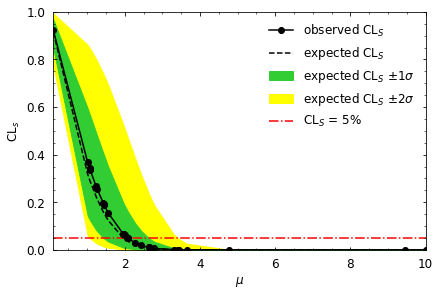

In [33]:
data_limit = [112, 129, 92, 63] + model.config.auxdata  # need auxiliary data as well
limit_results = cabinetry.fit.limit(model, data_limit)
cabinetry.visualize.limit(limit_results)

The observed limit follows the expectation quite closely with this new data we have used, which is very similar to the background-only prediction.

<br>

# Exploring the statistical model of an ATLAS analysis

Let's explore the statistical model used in an ATLAS search for electroweakinos: [Eur.Phys.J.C 80 (2020) 8, 691](https://inspirehep.net/literature/1755298). The corresponding likelihoods are available on HEPData: [doi:10.17182/hepdata.90607.v2](https://doi.org/10.17182/hepdata.90607.v2).

We can download it, pick one of the available signals with `pyhf`, and are ready to go.

In [34]:
download("https://www.hepdata.net/record/resource/1267798?view=true", "electroweakinos")
ATLAS_ws = pyhf.Workspace(json.load(open("electroweakinos/1Lbb-likelihoods-hepdata/BkgOnly.json")))
patchset = pyhf.PatchSet(json.load(open("electroweakinos/1Lbb-likelihoods-hepdata/patchset.json")))
ATLAS_ws = patchset.apply(ATLAS_ws, "C1N2_Wh_hbb_700_400")
cabinetry.workspace.save(ATLAS_ws, "electroweakinos.json")

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.patchset - Validating spec against schema: patchset.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to electroweakinos.json


<br>`pyhf` has a helpful command line interface utility to summarize the workspace content.

In [35]:
!pyhf inspect electroweakinos.json | head -n 6

                                    Summary       
                              ------------------  
                                 channels  8
                                  samples  10
                               parameters  120
                                modifiers  120


<br>

Let's extract model and data with `cabinetry`.

In [36]:
ATLAS_model, ATLAS_data = cabinetry.model_utils.model_and_data(ATLAS_ws)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier EG_Eff (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EG_Iso (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EG_RESOLUTION_ALL (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EG_Reco (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EG_SCALE_AF2 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EG_SCALE_ALL (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier JER_DataVsMC (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier JER_EffectiveNP_1 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier JER_EffectiveNP_10 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier JER_EffectiveNP_11 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier JER_EffectiveNP_12restTerm (1 new nuisance parameters)
INFO - pyhf.pdf - adding

INFO - pyhf.pdf - adding modifier mu_SIG (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_ST (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Top (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_W (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier SigXSec (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier trigger (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier diboson_XS (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier ttH_XS (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier ttv_XS (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier multiboson_XS (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier zjets_XS (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SRHMEM_mct2 (3 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SRLMEM_mct2 (3 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SRMMEM_mct2 (3 ne

<br>
We are ready to take a closer look at the content. Which phase space regions are included?

DEBUG - cabinetry.model_utils - total stdev is [[2.53, 1.74, 0.638], [3.11, 3.11, 2.15], [2.54, ..., 0.675], ..., [33.3], [13]]
DEBUG - cabinetry.model_utils - total stdev per channel is [3.66, 5.13, 2.69, 45.8, 49.4, 78.3, 33.3, 13]
INFO - cabinetry.visualize.utils - saving figure as figures/SRHMEM_mct2_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/SRLMEM_mct2_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/SRMMEM_mct2_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/STCREM_cuts_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/TRHMEM_cuts_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/TRLMEM_cuts_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/TRMMEM_cuts_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/WREM_cuts_prefit.pdf


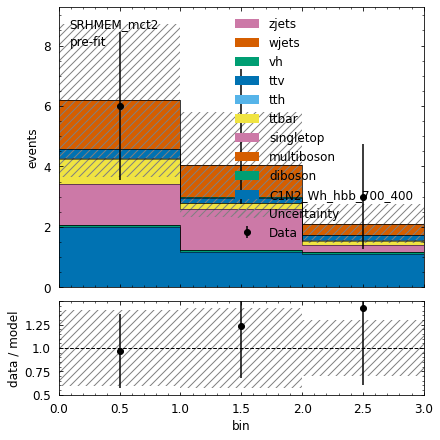

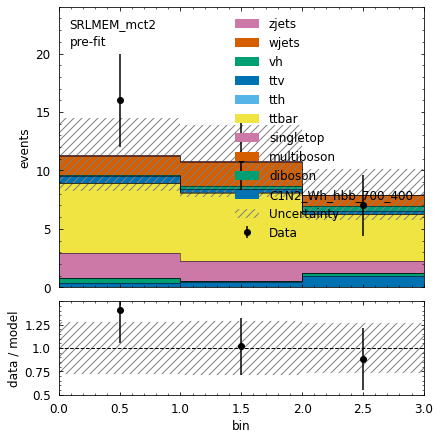

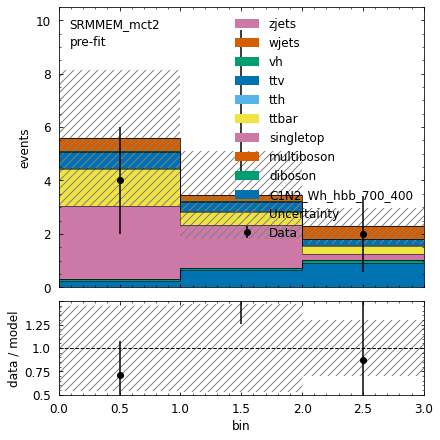

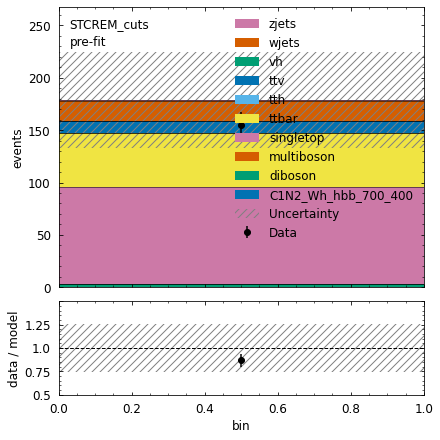

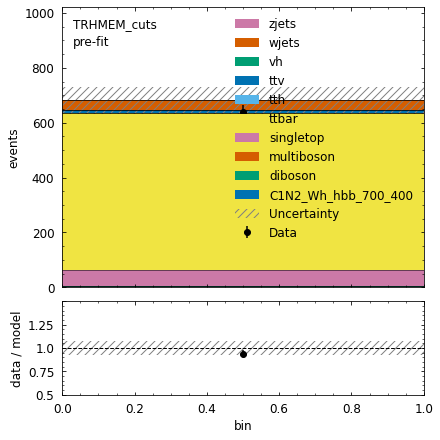

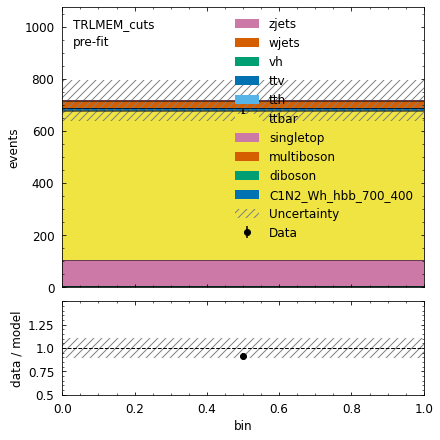

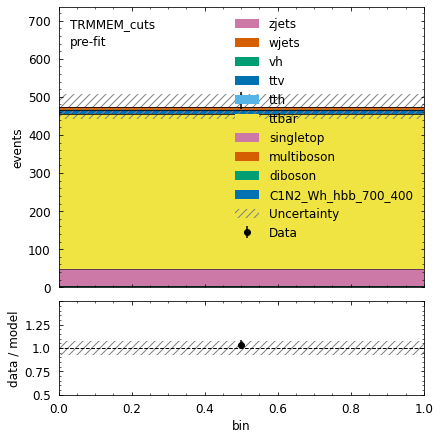

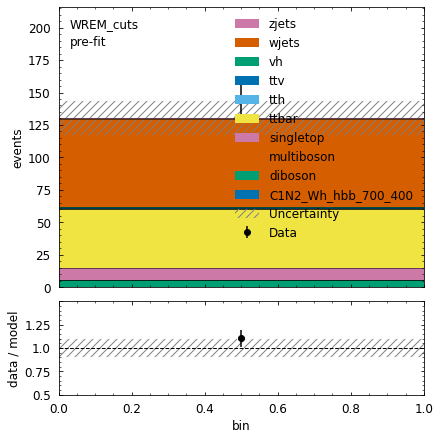

In [37]:
ATLAS_model_pred = cabinetry.model_utils.prediction(ATLAS_model)
_ = cabinetry.visualize.data_mc(ATLAS_model_pred, ATLAS_data)

<br>
Let's fit this model to data.

In [38]:
ATLAS_fit_results = cabinetry.fit.fit(ATLAS_model, ATLAS_data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 218.4                      │             Nfcn = 22347             │
│ EDM = 6e-05 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - singletopHardScattering                   =  0.5430 +/- 0.6059
INFO - cabinetry.fit - singletopISR                              =  0.2026 +/- 0.9777
INFO - cabinetry.fit - singletopInterference                     =  0.5221 +/- 0.9621
INFO - cabinetry.fit - TtbarFSR                                  = -0.0198 +/- 0.7195
INFO - cabinetry.fit - TtbarFragmentation                        =  0.3709 +/- 0.8978
INFO - cabinetry.fit - TtbarHardscattering                       =  0.2727 +/- 0.6473
INFO - cabinetry.fit - TtbarISR                                  = -0.1119 +/- 0.8241
INFO - cabinetry.fit - ttvRenormFac                              = -0.0062 +/- 0.9856
INFO - cabinetry.fit - wjetsCKKW                                 =  0.0060 +/- 1.0554
INFO - cabinetry.fit - wjetsPDF                                  =  0.0186 +/- 0.9932
INFO - cabinetry.fit - wjetsQSF                                  = -0.0047 +/- 1.0682
INFO - cabinetry.fit - wjetsRenormFac                 

<br>
To parse the results more easily, let's visualize them.

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


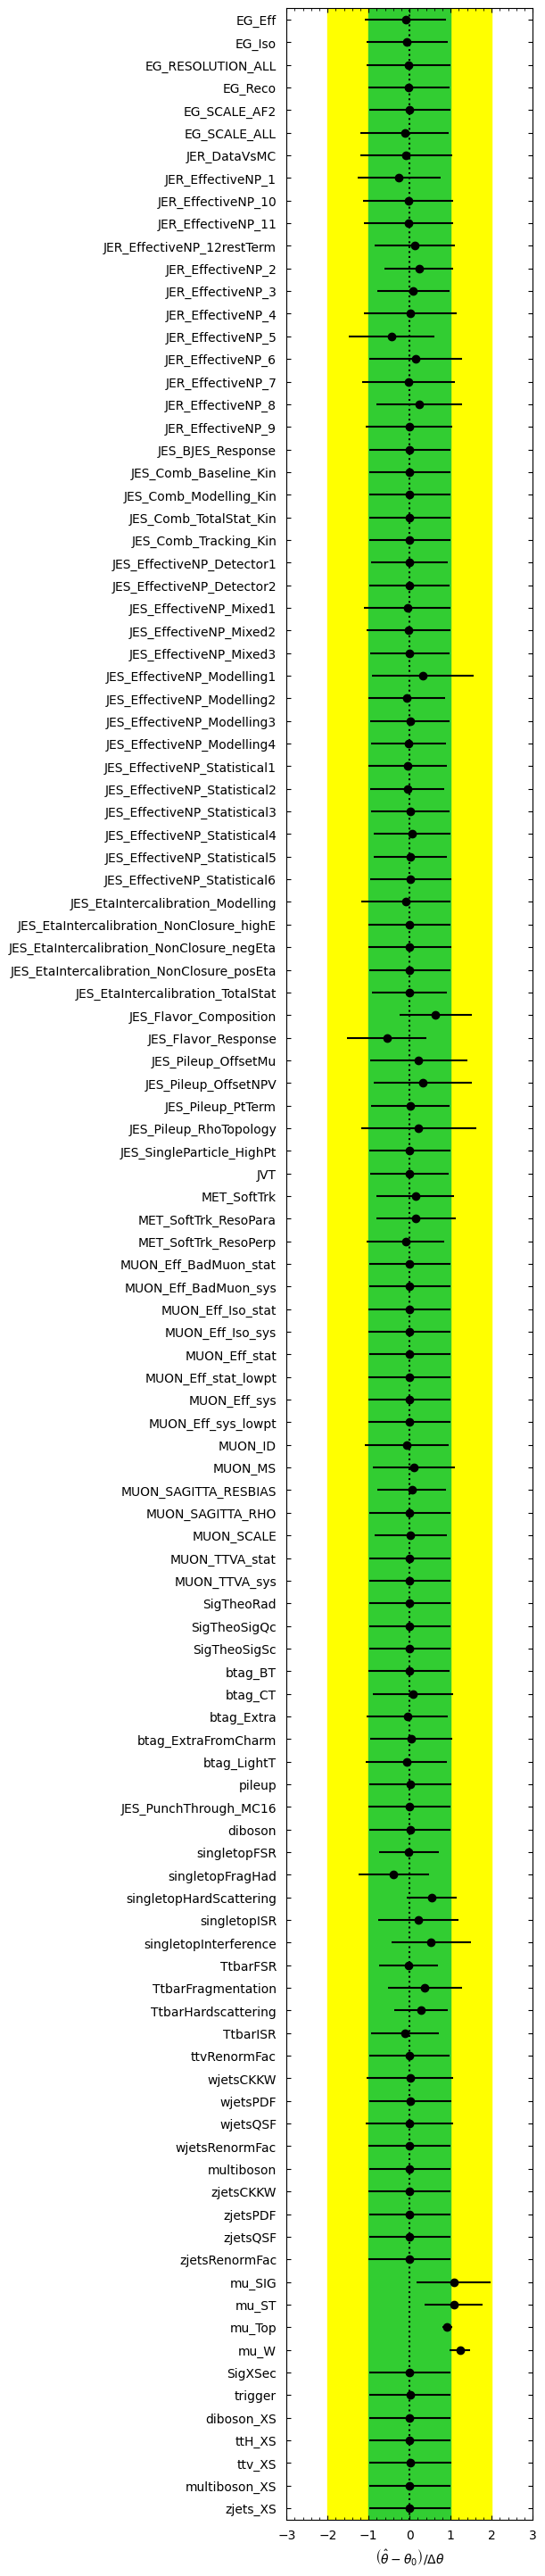

In [39]:
cabinetry.visualize.pulls(ATLAS_fit_results)

<br>

# Bonus material

Additional material that probably does not fit into the main talk. Check it out for more information!

<br>

### Command line interface

`cabinetry` also provides a [command line interface](https://cabinetry.readthedocs.io/en/latest/cli.html). Feel free to explore it!

In [40]:
! cabinetry --help

Usage: cabinetry [OPTIONS] COMMAND [ARGS]...

  Entrypoint to the cabinetry CLI.

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  templates      Produces template histograms.
  postprocess    Post-processes template histograms.
  workspace      Produces a ``pyhf`` workspace.
  fit            Fits a workspace and optionally visualizes the results.
  ranking        Ranks nuisance parameters and visualizes the result.
  scan           Performs and visualizes a likelihood scan over a parameter.
  limit          Calculates upper limits and visualizes CLs distribution.
  significance   Calculates observed and expected discovery significance.
  data-mc        Visualizes distributions of fit model and observed data.
  modifier-grid  Visualizes modifier structure of a model.


<br>

### Input histograms via a custom function

It is possible to inject custom code into `cabinetry`, which is used for template histogram creation. You can find more details in the [documentation](https://cabinetry.readthedocs.io/en/latest/advanced.html#overrides-for-template-building).

In [41]:
my_router = cabinetry.route.Router()

# define a custom template builder function that is executed for data samples
@my_router.register_template_builder(sample_name="Data")
def build_data_hist(region: dict, sample: dict, systematic: dict, template: str):
    hist = bh.Histogram(
        bh.axis.Variable(region["Binning"], underflow=False, overflow=False),
        storage=bh.storage.Weight(),
    )
    yields = np.asarray([17, 12, 25, 20])
    variance = np.asarray([1.5, 1.2, 1.8, 1.6])
    hist[...] = np.stack([yields, variance], axis=-1)
    return hist  # return a boost-histogram histogram

custom_config = copy.deepcopy(config)
custom_config["General"]["HistogramFolder"] = "histograms_custom/"
cabinetry.templates.build(custom_config, router=my_router)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.route - executing user-defined override build_data_hist
DEBUG - cabinetry.histo - saving histogram to histograms_custom/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms_custom/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_custom/Signal_region_Background.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms_custom/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBU

The histogram creation called our function to create the data histogram.

We can load the histogram and check the yields to verify they were correctly picked up.

In [42]:
h = cabinetry.histo.Histogram.from_path(pathlib.Path("histograms_custom/Signal_region_Data.npz"))
h.values()

array([17., 12., 25., 20.])

<br>

### Histogram smoothing

This shows how to apply smoothing to a histogram after producing it. We copy our config and save the resulting histograms in a new location to not interfere with the model we have used so far.

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Background.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -    

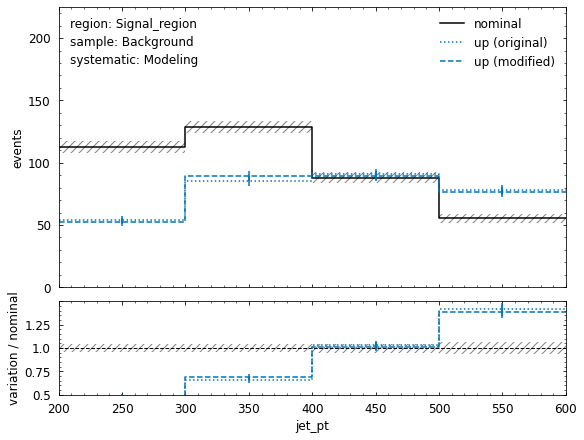

In [43]:
smoothing_config = copy.deepcopy(config)
smoothing_config["General"]["HistogramFolder"] = "histograms_smoothing/"
smoothing_config.update({
   "Systematics":[
      {
         "Name":"Modeling",
         "Up": {"SamplePath": "prediction.root", "Tree": "background_varied"},
         "Down": {"Symmetrize": True},
         "Samples": "Background",
         "Smoothing": {"Algorithm": "353QH, twice"},  # smoothing applied
         "Type": "NormPlusShape"
      }
   ]
})
cabinetry.templates.build(smoothing_config, method="uproot")
cabinetry.templates.postprocess(smoothing_config)
_ = cabinetry.visualize.templates(smoothing_config)

The original histogram is shown with the dotted line, and the dashed line shows the histogram after applying the [353QH, twice](https://cds.cern.ch/record/186223/) algorithm (same as `TH1::SmoothArray` in `ROOT`).

<br>

### Exploring histograms with `hist`

`cabinetry` uses `boost-histogram` internally to handle histograms. That means we can use `hist` for visualization. There are multiple ways for loading histograms, the method below uses information from the config.

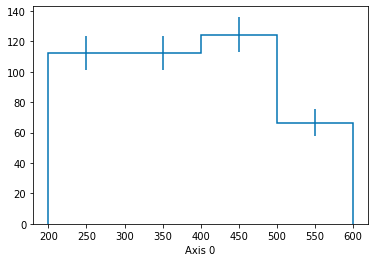

In [44]:
cabinetry_histogram = cabinetry.histo.Histogram.from_config(
    config["General"]["HistogramFolder"],
    config["Regions"][0],  # we only have one region: Signal_region
    config["Samples"][0],  # data
    {"Name": "Nominal"},   # no systematics
)
_ = hist.Hist(cabinetry_histogram).plot()

<br>

### Using a different `pyhf` backend

If your fits take a long time, or you have a GPU available and would like to make use of it, you can switch the computational backend used by `pyhf`. Set the backend via `pyhf` as you would in standalone use, and `cabinetry` will respect that choice.

In [45]:
pyhf.set_backend("tensorflow")
_ = cabinetry.fit.fit(model, data)
pyhf.set_backend("numpy")  # switch back to numpy

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │        Nfcn = 119, Ngrad = 9         │
│ EDM = 2.81e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

<br>

### Going back and forth between `cabinetry` and `pyhf`

You can go back and forth between `cabinetry` and `pyhf`. Here is a simple example that builds the Asimov dataset with `cabinetry` and performs a fit with `pyhf`.

In [46]:
asimov_data = cabinetry.model_utils.asimov_data(model)
pyhf.infer.mle.fit(asimov_data, model)

array([0., 0., 1., 0., 1., 1., 1., 1.])

<br>

You can also take advantage of the `pyhf` workspace format and edit parameters directly and then build a new model. Let's fix the `Modeling` nuisance parameter to `-0.5` and repeat the fit, this time with `cabinetry`. The model is obtained directly via `pyhf` here instead of using `cabinetry.model_utils.model_and_data`.

In [47]:
spec_edited = copy.deepcopy(spec)
spec_edited["measurements"][0]["config"]["parameters"].append({"name": "Modeling", "inits": [-0.5], "fixed": True})
model_edited = pyhf.Workspace(spec_edited).model()
_ = cabinetry.fit.fit(model_edited, data)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier Modeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier WeightBasedModeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Luminosity (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_Signal_region (4 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.29                      │              Nfcn = 209              │
│ EDM = 0.000122 (Goal: 0.0002)    │                                      │
├──────

The `Modeling` parameter shows up at its fixed value `-0.5` in the fit results, with an uncertainty of `0` since it is set to constant.

<br>

### Further MLE options: MINOS and goodness-of-fit

The `cabinetry.fit.fit` API allows use of the [MINOS algorithm](https://iminuit.readthedocs.io/en/stable/reference.html#iminuit.Minuit.minos) to compute confidence intervals via parameter scans. All parameters for which the algorithm should be run have to be listed.

In [48]:
_ = cabinetry.fit.fit(model, data, minos=["Signal_norm", "Modeling"])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 310              │
│ EDM = 2.82e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

MINOS uncertainties are not restricted to be symmetric by construction.

`cabinetry` also implementes a goodness-of-fit calculation using the [saturated model](http://www.physics.ucla.edu/~cousins/stats/cousins_saturated.pdf).

In [49]:
_ = cabinetry.fit.fit(model, data, goodness_of_fit=True)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 310              │
│ EDM = 2.82e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

<br>

### Likelihood scan

We can perform a likelihood scan, where we hold a parameter fixed at different values and perform a MLE for the other parameters, recording the likelihood at each step in the scan.

In [50]:
scan_results = cabinetry.fit.scan(model, data, "Signal_norm", n_steps=5)

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 310              │
│ EDM = 2.82e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 17.194232 at b

<br>
The scan in this example shows relatively good agreement with a naive Gaussian approximation.

INFO - cabinetry.visualize.utils - saving figure as figures/scan_Signal_norm.pdf


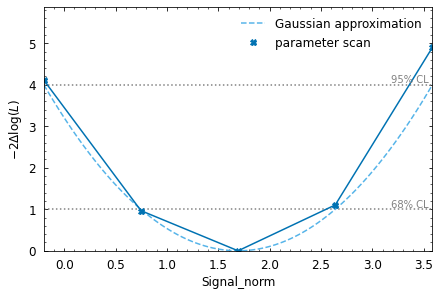

In [51]:
cabinetry.visualize.scan(scan_results)

<br>

### Nuisance parameter ranking

We can rank nuisance parameters (NPs) by their impact on the POI: how much does the POI change if the NP varies within its uncertainty? This requires a lot of MLE fits.

In [52]:
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results)

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.27                      │              Nfcn = 200              │
│ EDM = 4.39e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────

DEBUG - cabinetry.fit - -2 log(L) = 18.158379 at best-fit point
DEBUG - cabinetry.fit - POI is 2.455041, difference to nominal is 0.762336
INFO - cabinetry.fit - calculating impact of Luminosity on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.2                       │              Nfcn = 251              │
│ EDM = 4.64e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬──────

DEBUG - cabinetry.fit - -2 log(L) = 18.201607 at best-fit point
DEBUG - cabinetry.fit - POI is 1.796653, difference to nominal is 0.103949
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[1] on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.26                      │              Nfcn = 270              │
│ EDM = 4.77e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────

DEBUG - cabinetry.fit - -2 log(L) = 18.200966 at best-fit point
DEBUG - cabinetry.fit - POI is 1.800195, difference to nominal is 0.107491
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[3] on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.22                      │              Nfcn = 271              │
│ EDM = 1.59e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────

<br>
The figure visualizes the impact of nuisance parameters on the POI in order of decreasing impact.

INFO - cabinetry.visualize.utils - saving figure as figures/ranking.pdf


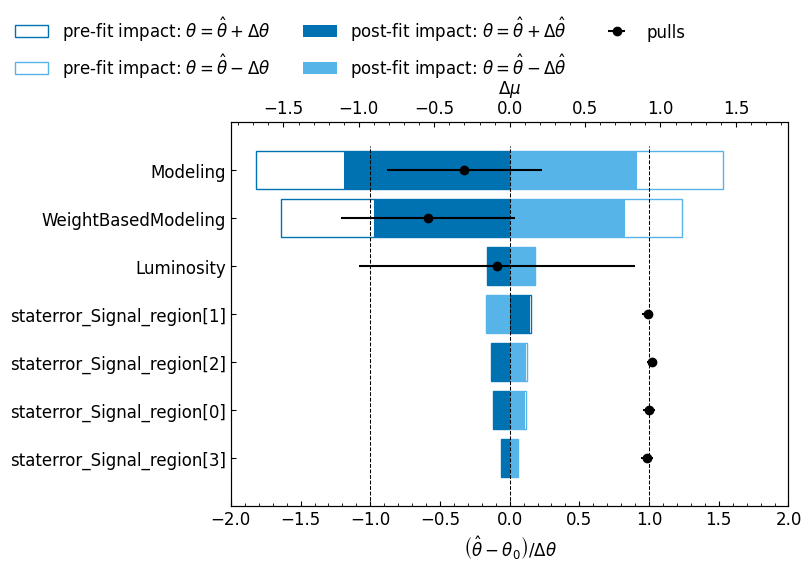

In [53]:
cabinetry.visualize.ranking(ranking_results)